In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

In [2]:
# Load Data
os.chdir(r'C:\Users\alanw\OneDrive\Varsity\Research\Experiments\dissertation')
df = pd.read_csv('UCI_Credit_Card_balanced.csv')

The data set is licensed under a [CC0 1.0](https://creativecommons.org/publicdomain/zero/1.0/) licence.

In [3]:
# Scale Data
scaler = StandardScaler()
scaler.fit(df.drop('Y',axis=1))
scaled_features = scaler.fit_transform(df.drop('Y',axis=1))

In [4]:
# Split features and response variable
X = pd.DataFrame(scaled_features,columns=df.columns[:-1])
y = df['Y']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=69)

## Step 1: Find the optimal min_leaf

In [5]:
# Setup base tree
cart_initial = DecisionTreeClassifier(random_state=69)

# Fit tree
cart_initial.fit(X_train,y_train)

DecisionTreeClassifier(random_state=69)

In [6]:
# View accuracy prior to pruning
y_pred = cart_initial.predict(X_test)
test_score = accuracy_score(y_test, y_pred)

# Print the test score
print("Accuracy score of the tree = {:2.2%}".format(test_score)) 

Accuracy score of the tree = 72.89%


In [7]:
print("Tree depth =",cart_initial.get_depth(),'\n'
      "Number of leaves =",cart_initial.get_n_leaves())

Tree depth = 43 
Number of leaves = 4865


In [8]:
# define search space
param_grid = dict()
param_grid['min_samples_leaf'] = list(range(1,50))
param_grid['criterion'] = ['gini', 'entropy']

# Set up model and Gridsearch
cart_gridsearch = DecisionTreeClassifier(random_state=69)
grid = GridSearchCV(cart_gridsearch, param_grid = param_grid, scoring='accuracy', cv=3)

# fit grid on full data
grid_results = grid.fit(X, y)

In [13]:
# summarize results
print("Best using %s" % (grid_results.best_params_))

min_samples_per_leaf = grid_results.best_params_["min_samples_leaf"]
criterion = grid_results.best_params_["criterion"]

Best using {'criterion': 'gini', 'min_samples_leaf': 49}


## Step 2: Perform Cost complexity Pruning

Split the data to grow the large tree stopping only when the terminal node contains fewer than some minimum number of observations. For example, we will keep dividing until each region has less than 20 data points.

In [14]:
# Set up tree with optimal parameters
cart_pruning = DecisionTreeClassifier(random_state=69, 
    min_samples_leaf = min_samples_per_leaf,
    criterion = criterion)

# Fit tree (Grow full tree)
cart_pruning.fit(X_train,y_train)

DecisionTreeClassifier(min_samples_leaf=49, random_state=69)

In [15]:
# View accuracy prior to pruning
y_pred = cart_pruning.predict(X_test)
test_score = accuracy_score(y_test, y_pred)

# Print the test score
print("Accuracy score of the tree = {:2.2%}".format(test_score)) 

Accuracy score of the tree = 74.63%


In [16]:
# Check the effect of pruning on the Decision Tree
path = cart_pruning.cost_complexity_pruning_path(X_train, y_train)

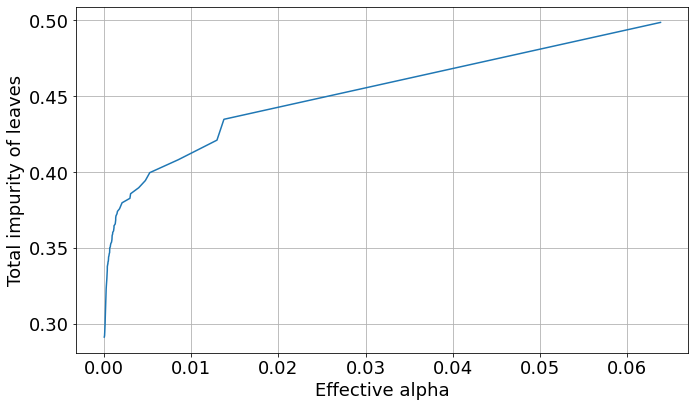

In [29]:
ccp_alphas, impurities = path.ccp_alphas, path.impurities

plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, impurities)

label_font = {'size':'18'}
plt.xlabel("Effective alpha", fontdict=label_font)
plt.ylabel("Total impurity of leaves", fontdict=label_font)
plt.grid()

font = {'size'   : 18}
plt.rc('font', **font)

plt.tight_layout()
plt.savefig(r'C:\Users\alanw\OneDrive\Varsity\Research\Paper Itself\LaTeX\images\prune_path.png')
plt.show()

In [23]:
clfs = []

for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

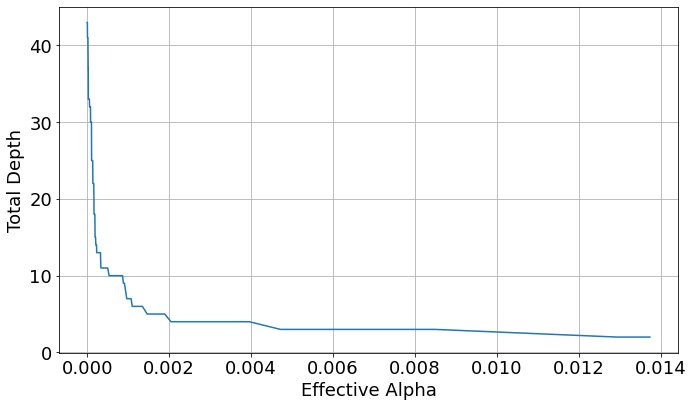

In [28]:
tree_depths = [clf.tree_.max_depth for clf in clfs]

plt.figure(figsize=(10,  6))

plt.grid()
plt.plot(ccp_alphas[:-1], tree_depths[:-1])
plt.ylabel("Total Depth")
plt.xlabel("Effective Alpha")

font = {'size'   : 18}
plt.rc('font', **font)

plt.tight_layout()
plt.savefig(r'C:\Users\alanw\OneDrive\Varsity\Research\Paper Itself\LaTeX\images\depth_alpha.png')
plt.show()

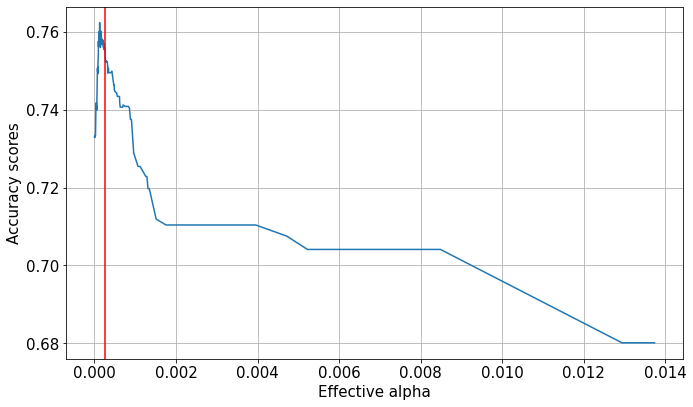

In [27]:
acc_scores = [accuracy_score(y_test, clf.predict(X_test)) for clf in clfs]

tree_depths = [clf.tree_.max_depth for clf in clfs]
plt.figure(figsize=(10,  6))
plt.grid()
plt.plot(ccp_alphas[:-1], acc_scores[:-1])
plt.xlabel("Effective alpha")
plt.ylabel("Accuracy scores")

font = {'size'   : 18}
plt.rc('font', **font)

plt.tight_layout()
plt.axvline(x=0.00025, c="Red")
plt.savefig(r'C:\Users\alanw\OneDrive\Varsity\Research\Paper Itself\LaTeX\images\accuracy_alpha.png')
plt.show()

In [37]:
max_accuracy = max(acc_scores)
print("Accuracy score of the tree = {:2.2%}".format(max_accuracy)) 


Accuracy score of the tree = 76.22%


By eye-balling it, it seems we achieve max-accuracy at $\alpha = 0.00025$

In [38]:
cart_final = DecisionTreeClassifier(random_state=69, ccp_alpha=0.00025, criterion="gini")
cart_final.fit(X_train, y_train)

y_pred = cart_final.predict(X_test)
test_score = accuracy_score(y_test, y_pred)

In [39]:
# Print the test score.
print("Accuracy score of the tree = {:2.2%}".format(test_score)) 

Accuracy score of the tree = 76.22%


In [40]:
print("Tree depth =", cart_final.get_depth(),'\n'
      "Number of leaves =", cart_final.get_n_leaves())

Tree depth = 13 
Number of leaves = 120


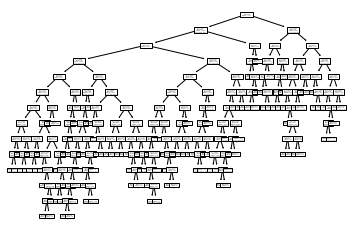

<Figure size 432x288 with 0 Axes>

In [41]:
# Plot of full tree
plt.figure()
plot_tree(cart_final,feature_names=X.columns)
plt.show()

plt.tight_layout()
plt.savefig(r'C:\Users\alanw\OneDrive\Varsity\Research\Paper Itself\LaTeX\images\dtree_class1.png')
plt.show()